In [7]:
!pip install opencv-python
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 196.9 MB/s eta 0:00:00


In [8]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
from multiprocessing import Pool
import os
#import cv2
import multiprocessing as mp
from skimage import feature
from skimage.measure import shannon_entropy

import pandas as pd

In [13]:


# Change to the directory containing the images
os.chdir('images_output/output_images')

# List of available image files in the directory
available_images = set(os.listdir('.'))

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)

Current working directory: /home/jovyan/images_output/output_images


In [53]:
#Color histogram

import cv2
import numpy as np

def compute_histogram(image, histSize=256, histRange=(0, 256)):
    bgr_planes = cv2.split(image)
    b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange)
    g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange)
    r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange)
    
    cv2.normalize(b_hist, b_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(r_hist, r_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    histogram = np.concatenate((b_hist, g_hist, r_hist)).flatten()
    return histogram

In [91]:
#Local Binary Pattern (LBP):


'''LBP works by comparing the intensity of a central pixel in a small neighborhood with the intensity of 
its surrounding pixels. Each pixel in the neighborhood is assigned a binary value based on 
whether its intensity is greater than or less than the intensity of the central pixel (threshold). 
These binary values are then concatenated into a binary number, which represents the texture of that neighborhood.'''

from skimage import feature

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = feature.local_binary_pattern(gray, P=24, R=8, method="uniform")
    # Histogram of LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist


In [55]:
def extract_background_simplicity(image):
    edges = cv2.Canny(image, 100, 200)
    simplicity = np.sum(edges) / edges.size
    return simplicity


In [75]:
from skimage.measure import shannon_entropy

def extract_color_entropy(image):
    hist = compute_histogram(image)
    entropy = shannon_entropy(hist)
    return entropy


In [88]:


# Function to extract brightness, contrast, and colorfulness
def extract_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.mean(hsv[:, :, 2])
    return brightness

def extract_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contrast = gray.std()
    return contrast

def extract_colorfulness(image):
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    stdRoot = np.sqrt((rg ** 2).mean() + (yb ** 2).mean())
    meanRoot = np.sqrt(rg.mean() ** 2 + yb.mean() ** 2)
    colorfulness = stdRoot + (0.3 * meanRoot)
    return colorfulness

# Function to extract features from an image path
def extract_features(image):
    #img_name = os.path.basename(img_path)

    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    features = {}
    features['color_hist'] = compute_histogram(image)
    features['contrast'] = extract_contrast(image)
    features['lbp'] = extract_lbp(image)
    features['brightness'] = extract_brightness(image)
    features['background_simplicity'] = extract_background_simplicity(image)
    features['colorfulness'] = extract_colorfulness(image)
    features['color_entropy'] = extract_color_entropy(image)
    return features
'''else:
        print(f"Image not found: {img_path}")
        features = {}
        features['color_hist'] = 0.0
        features['contrast'] = 0.0
        features['lbp'] = 0.0
        features['brightness'] = 0.0
        features['background_simplicity'] = 0.0
        features['colorfulness'] = 0.0
        features['color_entropy'] = 0.0
        return features'''




def save_features_to_npy(image_paths):
    output_dir = 'low_lvl_image_features'
    os.makedirs(output_dir, exist_ok=True)
    for image_path in image_paths:
        image = cv2.imread(image_path)
        
        features = extract_features(image)
        image_name = os.path.basename(image_path)
        for key, value in features.items():
            feature_path = os.path.join(output_dir, f"{image_name}_{key}.npy")
            np.save(feature_path, value)

In [11]:
# Navigate back to the root directory -- do it 2 times
os.chdir('..')
os.chdir('..')



# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)



Current working directory: /home/jovyan


In [3]:
import os

merged_posts_data = pd.read_csv('filtered_mapped_posts_2k_per_inflCateg.csv')

merged_posts_data_no_duplicates = merged_posts_data.drop_duplicates()


# Construct the image file name and check if it exists in the directory
merged_posts_data_no_duplicates['constructed_file_name'] = merged_posts_data_no_duplicates['OwnerUsername'] + '-' + merged_posts_data_no_duplicates['Image_file_name'] 

# Change to the directory containing the images
os.chdir('images_output/output_images')

# List of available image files in the directory
available_images = set(os.listdir('.'))


# Navigate back to the root directory -- do it 2 times
os.chdir('..')
os.chdir('..')

# Get the current working directory
current_dir = os.getcwd()
print("Current working directory:", current_dir)


# Filter the DataFrame to only include rows with existing images
filtered_df = merged_posts_data_no_duplicates[merged_posts_data_no_duplicates['constructed_file_name'].isin(available_images)]

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

# Apply label encoding to the 'Category' column
filtered_df['CategoryEncoded'] = pd.factorize(filtered_df['Category'])[0]

metadata_columns = ['PostID', 'ImageWidth', 'ImageHeight', 'CategoryEncoded', 'OwnerID', 'CommentsCount', '#Followers', '#Followees', '#Posts']
filtered_df = filtered_df[['constructed_file_name'] + metadata_columns + ['LikesNum']]


    


/tmp/ipykernel_134/1682639279.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_posts_data_no_duplicates['constructed_file_name'] = merged_posts_data_no_duplicates['OwnerUsername'] + '-' + merged_posts_data_no_duplicates['Image_file_name']


Current working directory: /home/jovyan


/tmp/ipykernel_134/1682639279.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['CategoryEncoded'] = pd.factorize(filtered_df['Category'])[0]


In [4]:
print(filtered_df['PostID'].dtype)
filtered_df['PostID'] = filtered_df['PostID'].astype(str)

## 1540631992910431459
dfff = filtered_df[filtered_df['PostID']=='1540631992910431459']  #'1896535069961354860' #1764973695170519501

dfff['constructed_file_name'].to_list()

int64


['fredbaierjr-1540631541485798570.jpg', 'fredbaierjr-1540631982348963186.jpg']

In [16]:
dfff['constructed_file_name'].to_list()


['jordanhefler-1896533999079959560.jpg',
 'jordanhefler-1896534007569376702.jpg',
 'jordanhefler-1896534017811791152.jpg',
 'jordanhefler-1896534029799223578.jpg',
 'jordanhefler-1896534034622533248.jpg',
 'jordanhefler-1896534043640325572.jpg',
 'jordanhefler-1896534051659720341.jpg',
 'jordanhefler-1896534060644024200.jpg',
 'jordanhefler-1896534062212763393.jpg',
 'jordanhefler-1896534106504538166.jpg']

In [92]:
# Extract low-level features in parallel



def save_features_to_npy(image_path):
    output_dir = 'low_lvl_image_features1'
    os.makedirs(output_dir, exist_ok=True)
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read the image file {image_path}")
        return

    features = extract_features(image)
    image_name = os.path.basename(image_path)
    for key, value in features.items():
        feature_path = os.path.join(output_dir, f"{image_name}_{key}.npy")
        np.save(feature_path, value)




image_dir = 'images_output/output_images'
img_paths = [os.path.join(image_dir, filtered_df.iloc[idx]['constructed_file_name']) for idx in range(len(filtered_df))]

# Extract low-level features in parallel
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    pool.map(save_features_to_npy, img_paths)
    pool.close()
    pool.join()

print("Process complete.")




Process complete.


In [ ]:
import shutil

output_dir = 'low_lvl_image_features'

# Delete the directory and all its contents
shutil.rmtree(output_dir)


In [1]:
import os

output_dir = 'low_lvl_image_features1'

len(os.listdir(output_dir))

11764543

In [78]:
image = cv2.imread(img_paths[0])
if image is None:
    print(f"Warning: Unable to read the image file {image_path}")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
compute_histogram(image) 

extract_features(image)

{'color_hist': array([4.68583591e-02, 0.00000000e+00, 1.38445152e-02, 1.59744397e-02,
        1.91693287e-02, 2.23642178e-02, 2.98189558e-02, 5.00532463e-02,
        6.28328025e-02, 6.92225769e-02, 7.66773149e-02, 1.17145896e-01,
        1.53354630e-01, 2.07667723e-01, 2.27902025e-01, 3.33333313e-01,
        5.25026619e-01, 5.35676241e-01, 7.32694328e-01, 7.44408906e-01,
        7.61448324e-01, 9.40362096e-01, 8.83919060e-01, 8.94568682e-01,
        9.31842387e-01, 1.00000000e+00, 9.95740116e-01, 9.66986120e-01,
        9.78700757e-01, 9.17997837e-01, 9.30777431e-01, 8.83919060e-01,
        8.83919060e-01, 8.83919060e-01, 8.28540981e-01, 8.09371650e-01,
        8.75399351e-01, 7.84877539e-01, 8.11501563e-01, 7.95527160e-01,
        7.71032989e-01, 7.76357830e-01, 7.49733746e-01, 7.79552698e-01,
        7.74227917e-01, 7.62513280e-01, 7.42278993e-01, 7.42278993e-01,
        6.78381264e-01, 7.28434503e-01, 6.64536715e-01, 6.94355667e-01,
        6.44302428e-01, 6.59211934e-01, 5.78274727

In [60]:
img = img_paths[0]

In [20]:
images = dfff['constructed_file_name'].to_list()


In [18]:
list(available_images)



'annkurtoglyan-1759465771320535055.jpg'

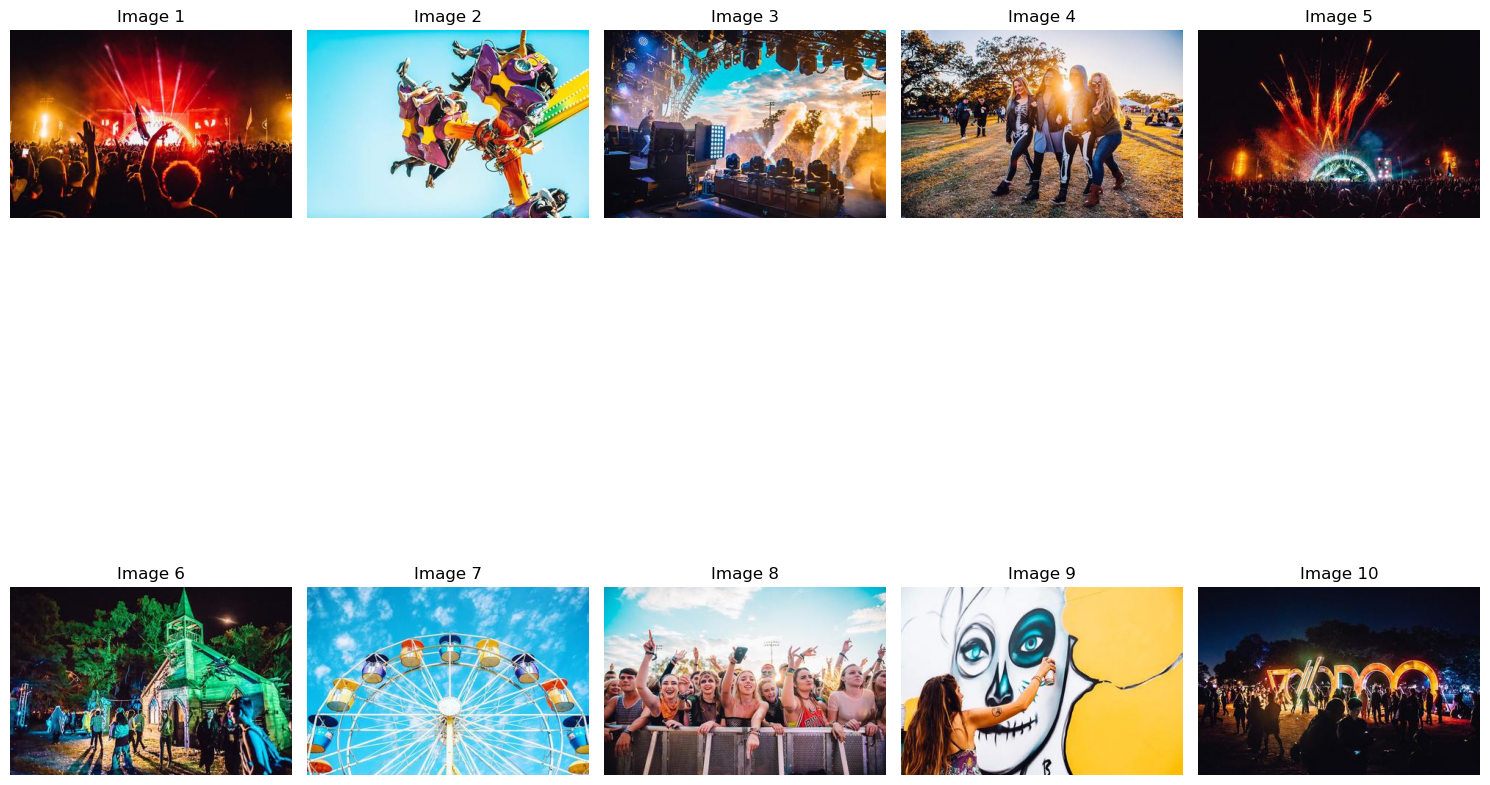

In [21]:
import matplotlib.pyplot as plt
import cv2

# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(15, 15))
    
    for i, image_path in enumerate(image_paths):
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        
        # Check if the image was loaded correctly
        if img is not None:
            # Convert the image from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Create a subplot for each image
            plt.subplot(2, 5, i + 1)  # Arrange images in a 2x5 grid
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f"Image {i+1}")
        else:
            print(f"Error: Could not read image {image_path}")
    
    plt.tight_layout()
    plt.show()

# Display the images from the list
display_images(images)


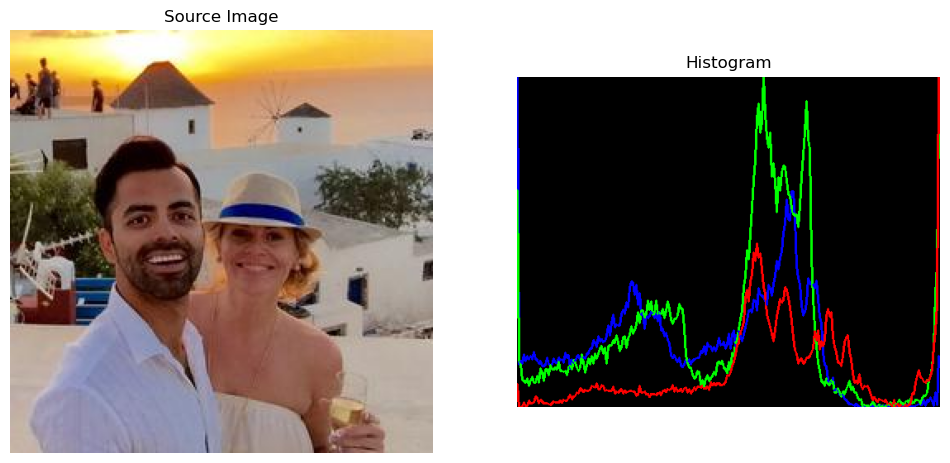

In [8]:
import cv2 as cv
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = list(available_images)[0]

# Load the image
src = cv.imread(image_path)
if src is None:
    print('Could not open or find the image:', image_path)
    exit(0)

# Split the image into its BGR planes
bgr_planes = cv.split(src)

# Set histogram parameters
histSize = 256
histRange = (0, 256)  # the upper boundary is exclusive
accumulate = False

# Calculate histograms for each color channel
b_hist = cv.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
g_hist = cv.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
r_hist = cv.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)

# Create an image to display the histograms
hist_w = 512
hist_h = 400
bin_w = int(round(hist_w/histSize))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)

# Normalize the histograms
cv.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
cv.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
cv.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)

# Draw the histograms
for i in range(1, histSize):
    cv.line(histImage, (bin_w*(i-1), hist_h - int(b_hist[i-1])),
            (bin_w*(i), hist_h - int(b_hist[i])),
            (255, 0, 0), thickness=2)
    cv.line(histImage, (bin_w*(i-1), hist_h - int(g_hist[i-1])),
            (bin_w*(i), hist_h - int(g_hist[i])),
            (0, 255, 0), thickness=2)
    cv.line(histImage, (bin_w*(i-1), hist_h - int(r_hist[i-1])),
            (bin_w*(i), hist_h - int(r_hist[i])),
            (0, 0, 255), thickness=2)

# Save the histogram image
hist_image_path = 'histogram.png'
cv.imwrite(hist_image_path, histImage)

# Display the source and histogram images using matplotlib
src_rgb = cv.cvtColor(src, cv.COLOR_BGR2RGB)
hist_image = Image.open(hist_image_path)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(src_rgb)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(hist_image)
axs[1].set_title('Histogram')
axs[1].axis('off')

plt.show()


In [13]:
import cv2
import numpy as np



# Example usage
image = cv2.imread(image_path)
histogram_feature = compute_histogram(image)


In [23]:
extract_lbp(cv.imread(image_path))

(array([[ 7.,  7.,  8., ...,  2.,  2.,  3.],
        [ 7.,  7.,  8., ...,  1.,  1.,  2.],
        [ 7.,  7.,  8., ...,  1.,  1.,  1.],
        ...,
        [ 0.,  0., 25., ...,  7., 25., 25.],
        [25.,  0.,  0., ..., 25., 25., 25.],
        [ 5.,  2.,  0., ...,  1.,  0.,  0.]]),
 array([0.03114319, 0.02781677, 0.0120697 , 0.01036072, 0.00889587,
        0.0088501 , 0.00895691, 0.01065063, 0.01095581, 0.01429749,
        0.01879883, 0.027771  , 0.04920959, 0.03707886, 0.01792908,
        0.01335144, 0.00947571, 0.00810242, 0.00598145, 0.00720215,
        0.0078125 , 0.00938416, 0.01219177, 0.02578735, 0.03106689,
        0.57485962]))